# Measuring the effectiveness of trainable quantum neural networks

To find out which of our designed circuits has any real, reproducable value, we will run each of them various times to see how they perform

In [94]:
#imports
import csv

import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit.visualization import plot_state_qsphere
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import *
import qiskit.quantum_info as qi

from qiskit.tools.visualization import plot_histogram, plot_state_city

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from typing import Union

from qiskit_machine_learning.exceptions import QiskitMachineLearningError

from IPython.display import clear_output

import warnings
warnings.simplefilter('ignore')

import random
import time

random.seed(69069)
np.random.seed(69069)

In [95]:
#create folder for figures
import os
path = '../figures/IRIS/non_randomized_split/'
training_measurments_path = '../training_measurments/IRIS/non_randomized_split/'
try:
    os.makedirs(path)
except:
    print('path already exists!')

try:
    os.makedirs(training_measurments_path)
except:
    print('path already exists!')

path already exists!


In [32]:
#code to normalize features to a range of -1 and 1
from sklearn.preprocessing import MinMaxScaler

def normalize_data(data):
    return MinMaxScaler().fit_transform(data) * 2 - 1

#code to normalize features to a range of -pi and pi
def pifi_data(data):
    return MinMaxScaler().fit_transform(data) * 2 * np.pi - np.pi

#code to leave features as is
def as_is(data):
    return data


## IRIS tests
We will now create the circuits needed for the IRIS tests

In [66]:
#Arrays
circuits = []
datasets = []
accuracy = []
n_shots = 1024

#Data
dataset = load_iris()
data = dataset['data']
targets = np.array(dataset['target'])

simulator_gpu = Aer.get_backend('aer_simulator')
simulator_gpu.set_options(device='GPU')
quantum_instance = QuantumInstance(simulator_gpu, shots=n_shots)

datasets.append(data)
datasets.append(normalize_data(data))
datasets.append(pifi_data(data))

n_features = len(data[0])

output_shape = 3
def parity(x):
    return '{:b}'.format(x).count('1') % 3

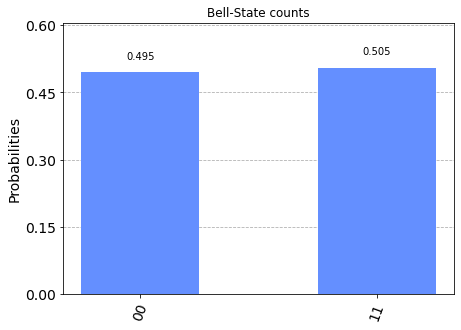

In [34]:
####CHECK IF GPU WORKS
circ = QuantumCircuit(2)
circ.h(0)
circ.cx(0, 1)
circ.measure_all()

# Transpile for simulator
circ = transpile(circ, simulator_gpu)

# Run and get counts
result = simulator_gpu.run(circ).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Bell-State counts')

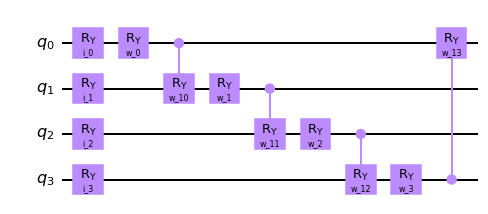

In [35]:
feature_map = QuantumCircuit(4)
ansatz = QuantumCircuit(4)
for i in range(len(data[1])):
    feature_map.ry(Parameter('i_' + str(i)),i)
    ansatz.ry(Parameter('w_' + str(i)),i)
    ansatz.cry(Parameter('w_' + str(10+i)), i, (i+1)%4)


qc = QuantumCircuit(4)
qc.append(feature_map, range(4))
qc.append(ansatz, range(4))

circuits.append(qc.decompose().copy())
circuits[-1].draw('mpl')

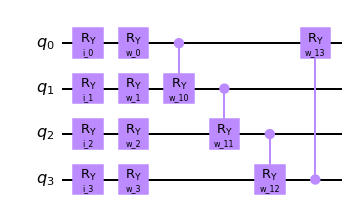

In [36]:
feature_map = QuantumCircuit(4)
ansatz = QuantumCircuit(4)
for i in range(len(data[1])):
    feature_map.ry(Parameter('i_' + str(i)),i)
    ansatz.ry(Parameter('w_' + str(i)),i)

for i in range(len(data[1])):
    ansatz.cry(Parameter('w_' + str(10+i)), i, (i+1)%4)


qc = QuantumCircuit(4)
qc.append(feature_map, range(4))
qc.append(ansatz, range(4))

circuits.append(qc.decompose().copy())
circuits[-1].draw('mpl')

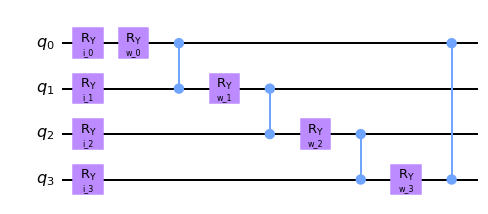

In [37]:
feature_map = QuantumCircuit(4)
ansatz = QuantumCircuit(4)
for i in range(len(data[1])):
    feature_map.ry(Parameter('i_' + str(i)),i)
    ansatz.ry(Parameter('w_' + str(i)),i)
    ansatz.cz(i, (i+1)%4)


qc = QuantumCircuit(4)
qc.append(feature_map, range(4))
qc.append(ansatz, range(4))

circuits.append(qc.decompose().copy())
circuits[-1].draw('mpl')

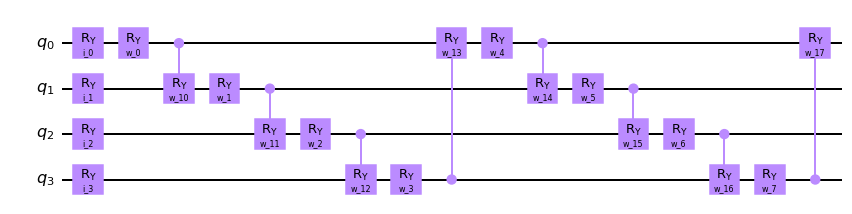

In [38]:
feature_map = QuantumCircuit(4)
ansatz = QuantumCircuit(4)
for i in range(len(data[1])):
    feature_map.ry(Parameter('i_' + str(i)),i)
    ansatz.ry(Parameter('w_' + str(i)),i)
    ansatz.cry(Parameter('w_' + str(10+i)), i, (i+1)%4)


for i in range(len(data[1])):
    ansatz.ry(Parameter('w_' + str(i+4)),i)
    ansatz.cry(Parameter('w_' + str(10+i+4)), i, (i+1)%4)

qc = QuantumCircuit(4)
qc.append(feature_map, range(4))
qc.append(ansatz, range(4))

circuits.append(qc.decompose().copy())
circuits[-1].draw('mpl')

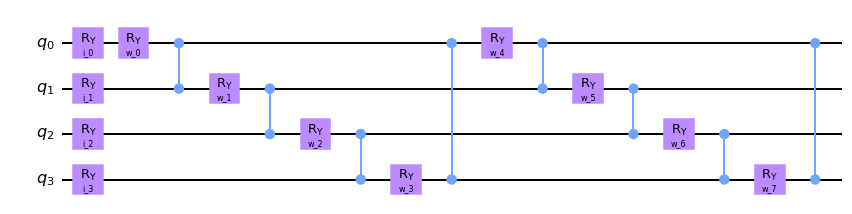

In [39]:
feature_map = QuantumCircuit(4)
ansatz = QuantumCircuit(4)
for i in range(len(data[1])):
    feature_map.ry(Parameter('i_' + str(i)),i)
    ansatz.ry(Parameter('w_' + str(i)),i)
    ansatz.cz(i, (i+1)%4)


for i in range(len(data[1])):
    ansatz.ry(Parameter('w_' + str(i+4)),i)
    ansatz.cz(i, (i+1)%4)

qc = QuantumCircuit(4)
qc.append(feature_map, range(4))
qc.append(ansatz, range(4))

circuits.append(qc.decompose().copy())
circuits[-1].draw('mpl')

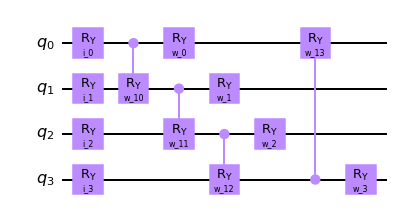

In [40]:
feature_map = QuantumCircuit(4)
ansatz = QuantumCircuit(4)
for i in range(len(data[1])):
    feature_map.ry(Parameter('i_' + str(i)),i)
    ansatz.cry(Parameter('w_' + str(10+i)), i, (i+1)%4)
    ansatz.ry(Parameter('w_' + str(i)),i)


qc = QuantumCircuit(4)
qc.append(feature_map, range(4))
qc.append(ansatz, range(4))

circuits.append(qc.decompose().copy())
circuits[-1].draw('mpl')

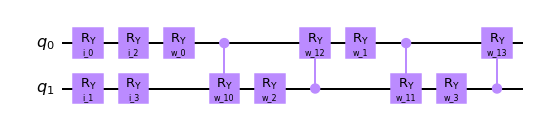

In [41]:
feature_map = QuantumCircuit(2)
ansatz = QuantumCircuit(2)
for i in range(2):
    feature_map.ry(Parameter('i_' + str(i)),i)
    feature_map.ry(Parameter('i_' + str(i+2)),i)
    ansatz.ry(Parameter('w_' + str(i)), 0)
    ansatz.cry(Parameter('w_' + str(10+i)), 0, 1)
    ansatz.ry(Parameter('w_' + str(i+2)), 1)
    ansatz.cry(Parameter('w_' + str(10+i+2)), 1, 0)


qc = QuantumCircuit(2)
qc.append(feature_map, range(2))
qc.append(ansatz, range(2))

circuits.append(qc.decompose().copy())
circuits[-1].draw('mpl')

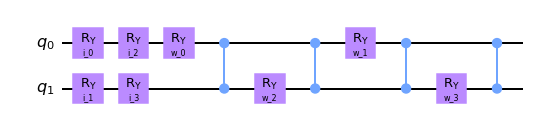

In [42]:
feature_map = QuantumCircuit(2)
ansatz = QuantumCircuit(2)
for i in range(2):
    feature_map.ry(Parameter('i_' + str(i)),i)
    feature_map.ry(Parameter('i_' + str(i+2)),i)
    ansatz.ry(Parameter('w_' + str(i)), 0)
    ansatz.cz(0, 1)
    ansatz.ry(Parameter('w_' + str(i+2)), 1)
    ansatz.cz(1, 0)


qc = QuantumCircuit(2)
qc.append(feature_map, range(2))
qc.append(ansatz, range(2))

circuits.append(qc.decompose().copy())
circuits[-1].draw('mpl')

### Functions needed for training

In [43]:
def fit_and_score(circuit_classifier, features, targets, random_state = 69069):
    X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=1-3/4, random_state=random_state)

    # fit classifier to data
    circuit_classifier.fit(X_train, y_train)
    score_train =  circuit_classifier.score(X_train, y_train)
    score_test =  circuit_classifier.score(X_test, y_test)
    print("Mean Accuracy training: " + str(score_train))
    print("Mean Accuracy testing: " + str(score_test))
    return score_train, score_test

def get_classifier(circuit):
    circuit_qnn = CircuitQNN(circuit=circuit,    
                         input_params=circuit.parameters[0:n_features],
                         weight_params=circuit.parameters[n_features:],
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

    # construct classifier
    return NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                                optimizer=COBYLA())

In [103]:
def plot_boxplots(run, title, circuit_index, save=False):
    min = np.amin(run)-0.01
    max = np.amax(run)+0.01
    fig = plt.figure()
    gs = fig.add_gridspec(1, 2, hspace=0, wspace=0)
    (ax1, ax2) = gs.subplots(sharex='col', sharey='row')
    ax1.set_ylim([min,max])
    ax2.set_ylim([min,max])
    fig.suptitle(title)
    ax1.set_title('Training')
    ax1.boxplot(run[0], showfliers=True, sym='k.')
    ax2.set_title('Testing')
    ax2.boxplot(run[1], showfliers=True, sym='k.')
    if(save):
        plt.savefig(path+title.replace(" ", "_")+'.svg', format="svg", transparent=True)
    display(plt.show())

In [44]:
#so
pure_runs = []

display(print("Testing unnormalized dataset"))
for circuit in circuits:
    training_data = []
    testing_data = []
    for i in range(10):
        display(print('run: ' + str(i+1)))
        classifier = get_classifier(circuit.copy())
        score_train, score_test = fit_and_score(classifier, datasets[0], targets)
        training_data.append(score_train)
        testing_data.append(score_test)
    display(print('Circuit done'))
    pure_runs.append([training_data, testing_data])

Testing unnormalized dataset


None

run: 1


None

Mean Accuracy training: 0.6964285714285714
Mean Accuracy testing: 0.6842105263157895
run: 2


None

Mean Accuracy training: 0.6696428571428571
Mean Accuracy testing: 0.6578947368421053
run: 3


None

Mean Accuracy training: 0.8303571428571429
Mean Accuracy testing: 0.8947368421052632
run: 4


None

Mean Accuracy training: 0.6875
Mean Accuracy testing: 0.6578947368421053
run: 5


None

Mean Accuracy training: 0.8392857142857143
Mean Accuracy testing: 0.868421052631579
run: 6


None

Mean Accuracy training: 0.6785714285714286
Mean Accuracy testing: 0.6578947368421053
run: 7


None

Mean Accuracy training: 0.9285714285714286
Mean Accuracy testing: 0.9473684210526315
run: 8


None

Mean Accuracy training: 0.8392857142857143
Mean Accuracy testing: 0.6578947368421053
run: 9


None

Mean Accuracy training: 0.6875
Mean Accuracy testing: 0.6578947368421053
run: 10


None

Mean Accuracy training: 0.6517857142857143
Mean Accuracy testing: 0.6578947368421053
Circuit done


None

run: 1


None

Mean Accuracy training: 0.8214285714285714
Mean Accuracy testing: 0.9210526315789473
run: 2


None

Mean Accuracy training: 0.9017857142857143
Mean Accuracy testing: 0.8947368421052632
run: 3


None

Mean Accuracy training: 0.7410714285714286
Mean Accuracy testing: 0.7631578947368421
run: 4


None

Mean Accuracy training: 0.7410714285714286
Mean Accuracy testing: 0.8421052631578947
run: 5


None

Mean Accuracy training: 0.7232142857142857
Mean Accuracy testing: 0.8947368421052632
run: 6


None

Mean Accuracy training: 0.6696428571428571
Mean Accuracy testing: 0.6578947368421053
run: 7


None

Mean Accuracy training: 0.7321428571428571
Mean Accuracy testing: 0.9210526315789473
run: 8


None

Mean Accuracy training: 0.7142857142857143
Mean Accuracy testing: 0.9210526315789473
run: 9


None

Mean Accuracy training: 0.6339285714285714
Mean Accuracy testing: 0.5789473684210527
run: 10


None

Mean Accuracy training: 0.7321428571428571
Mean Accuracy testing: 0.7368421052631579
Circuit done


None

run: 1


None

Mean Accuracy training: 0.7589285714285714
Mean Accuracy testing: 0.9210526315789473
run: 2


None

Mean Accuracy training: 0.7410714285714286
Mean Accuracy testing: 0.8947368421052632
run: 3


None

Mean Accuracy training: 0.8125
Mean Accuracy testing: 0.9473684210526315
run: 4


None

Mean Accuracy training: 0.8035714285714286
Mean Accuracy testing: 0.9473684210526315
run: 5


None

Mean Accuracy training: 0.7857142857142857
Mean Accuracy testing: 0.9210526315789473
run: 6


None

Mean Accuracy training: 0.8928571428571429
Mean Accuracy testing: 0.9473684210526315
run: 7


None

Mean Accuracy training: 0.7767857142857143
Mean Accuracy testing: 0.9210526315789473
run: 8


None

Mean Accuracy training: 0.9017857142857143
Mean Accuracy testing: 0.9210526315789473
run: 9


None

Mean Accuracy training: 0.75
Mean Accuracy testing: 0.9473684210526315
run: 10


None

Mean Accuracy training: 0.75
Mean Accuracy testing: 0.868421052631579
Circuit done


None

run: 1


None

Mean Accuracy training: 0.7410714285714286
Mean Accuracy testing: 0.868421052631579
run: 2


None

Mean Accuracy training: 0.6160714285714286
Mean Accuracy testing: 0.5263157894736842
run: 3


None

Mean Accuracy training: 0.6696428571428571
Mean Accuracy testing: 0.6578947368421053
run: 4


None

Mean Accuracy training: 0.9464285714285714
Mean Accuracy testing: 1.0
run: 5


None

Mean Accuracy training: 0.75
Mean Accuracy testing: 0.5789473684210527
run: 6


None

Mean Accuracy training: 0.6875
Mean Accuracy testing: 0.6052631578947368
run: 7


None

Mean Accuracy training: 0.7857142857142857
Mean Accuracy testing: 0.8421052631578947
run: 8


None

Mean Accuracy training: 0.7321428571428571
Mean Accuracy testing: 0.6052631578947368
run: 9


None

Mean Accuracy training: 0.5535714285714286
Mean Accuracy testing: 0.5263157894736842
run: 10


None

Mean Accuracy training: 0.75
Mean Accuracy testing: 0.631578947368421
Circuit done


None

run: 1


None

Mean Accuracy training: 0.9553571428571429
Mean Accuracy testing: 1.0
run: 2


None

Mean Accuracy training: 0.8839285714285714
Mean Accuracy testing: 0.9210526315789473
run: 3


None

Mean Accuracy training: 0.6785714285714286
Mean Accuracy testing: 0.7105263157894737
run: 4


None

Mean Accuracy training: 0.625
Mean Accuracy testing: 0.6052631578947368
run: 5


None

Mean Accuracy training: 0.8482142857142857
Mean Accuracy testing: 0.8947368421052632
run: 6


None

Mean Accuracy training: 0.625
Mean Accuracy testing: 0.631578947368421
run: 7


None

Mean Accuracy training: 0.8571428571428571
Mean Accuracy testing: 0.868421052631579
run: 8


None

Mean Accuracy training: 0.5714285714285714
Mean Accuracy testing: 0.5789473684210527
run: 9


None

Mean Accuracy training: 0.5982142857142857
Mean Accuracy testing: 0.631578947368421
run: 10


None

Mean Accuracy training: 0.7142857142857143
Mean Accuracy testing: 0.868421052631579
Circuit done


None

run: 1


None

Mean Accuracy training: 0.6339285714285714
Mean Accuracy testing: 0.631578947368421
run: 2


None

Mean Accuracy training: 0.6964285714285714
Mean Accuracy testing: 0.6842105263157895
run: 3


None

Mean Accuracy training: 0.6428571428571429
Mean Accuracy testing: 0.631578947368421
run: 4


None

Mean Accuracy training: 0.625
Mean Accuracy testing: 0.5263157894736842
run: 5


None

Mean Accuracy training: 0.7142857142857143
Mean Accuracy testing: 0.8947368421052632
run: 6


None

Mean Accuracy training: 0.625
Mean Accuracy testing: 0.631578947368421
run: 7


None

Mean Accuracy training: 0.8839285714285714
Mean Accuracy testing: 0.9210526315789473
run: 8


None

Mean Accuracy training: 0.7946428571428571
Mean Accuracy testing: 0.868421052631579
run: 9


None

Mean Accuracy training: 0.6517857142857143
Mean Accuracy testing: 0.6578947368421053
run: 10


None

Mean Accuracy training: 0.7767857142857143
Mean Accuracy testing: 0.7894736842105263
Circuit done


None

run: 1


None

Mean Accuracy training: 0.4375
Mean Accuracy testing: 0.47368421052631576
run: 2


None

Mean Accuracy training: 0.49107142857142855
Mean Accuracy testing: 0.6052631578947368
run: 3


None

Mean Accuracy training: 0.8035714285714286
Mean Accuracy testing: 0.7894736842105263
run: 4


None

Mean Accuracy training: 0.5446428571428571
Mean Accuracy testing: 0.6052631578947368
run: 5


None

Mean Accuracy training: 0.5535714285714286
Mean Accuracy testing: 0.5789473684210527
run: 6


None

Mean Accuracy training: 0.5714285714285714
Mean Accuracy testing: 0.6578947368421053
run: 7


None

Mean Accuracy training: 0.5267857142857143
Mean Accuracy testing: 0.5789473684210527
run: 8


None

Mean Accuracy training: 0.5803571428571429
Mean Accuracy testing: 0.6578947368421053
run: 9


None

Mean Accuracy training: 0.5803571428571429
Mean Accuracy testing: 0.6578947368421053
run: 10


None

Mean Accuracy training: 0.5982142857142857
Mean Accuracy testing: 0.6578947368421053
Circuit done


None

run: 1


None

Mean Accuracy training: 0.5803571428571429
Mean Accuracy testing: 0.6052631578947368
run: 2


None

Mean Accuracy training: 0.5535714285714286
Mean Accuracy testing: 0.631578947368421
run: 3


None

Mean Accuracy training: 0.5446428571428571
Mean Accuracy testing: 0.5789473684210527
run: 4


None

Mean Accuracy training: 0.5535714285714286
Mean Accuracy testing: 0.6052631578947368
run: 5


None

Mean Accuracy training: 0.5446428571428571
Mean Accuracy testing: 0.631578947368421
run: 6


None

Mean Accuracy training: 0.5625
Mean Accuracy testing: 0.631578947368421
run: 7


None

Mean Accuracy training: 0.5535714285714286
Mean Accuracy testing: 0.5789473684210527
run: 8


None

Mean Accuracy training: 0.5178571428571429
Mean Accuracy testing: 0.5789473684210527
run: 9


None

Mean Accuracy training: 0.5267857142857143
Mean Accuracy testing: 0.6052631578947368
run: 10


None

Mean Accuracy training: 0.5625
Mean Accuracy testing: 0.631578947368421
Circuit done


None

In [47]:
print(pure_runs)

[[[0.6964285714285714, 0.6696428571428571, 0.8303571428571429, 0.6875, 0.8392857142857143, 0.6785714285714286, 0.9285714285714286, 0.8392857142857143, 0.6875, 0.6517857142857143], [0.6842105263157895, 0.6578947368421053, 0.8947368421052632, 0.6578947368421053, 0.868421052631579, 0.6578947368421053, 0.9473684210526315, 0.6578947368421053, 0.6578947368421053, 0.6578947368421053]], [[0.8214285714285714, 0.9017857142857143, 0.7410714285714286, 0.7410714285714286, 0.7232142857142857, 0.6696428571428571, 0.7321428571428571, 0.7142857142857143, 0.6339285714285714, 0.7321428571428571], [0.9210526315789473, 0.8947368421052632, 0.7631578947368421, 0.8421052631578947, 0.8947368421052632, 0.6578947368421053, 0.9210526315789473, 0.9210526315789473, 0.5789473684210527, 0.7368421052631579]], [[0.7589285714285714, 0.7410714285714286, 0.8125, 0.8035714285714286, 0.7857142857142857, 0.8928571428571429, 0.7767857142857143, 0.9017857142857143, 0.75, 0.75], [0.9210526315789473, 0.8947368421052632, 0.947368

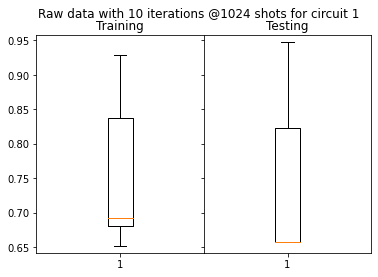

None

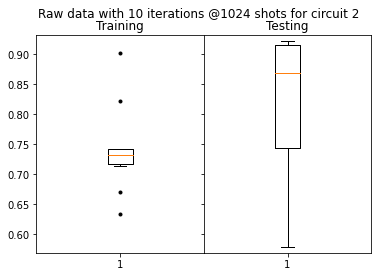

None

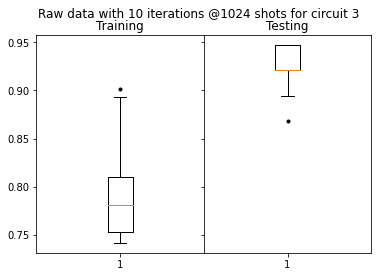

None

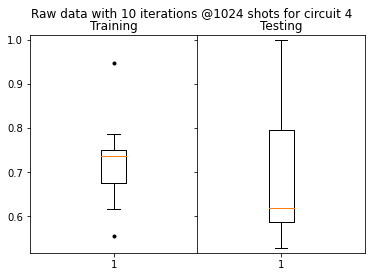

None

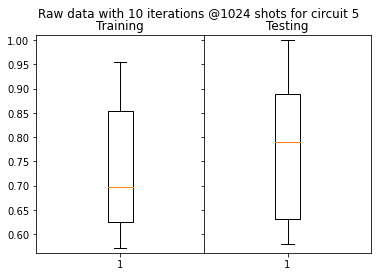

None

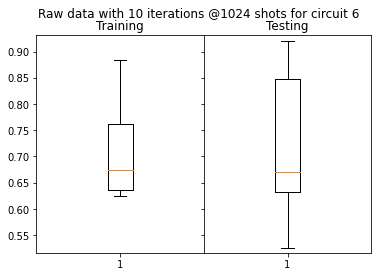

None

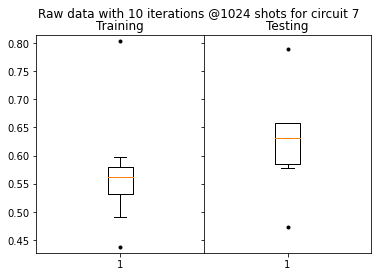

None

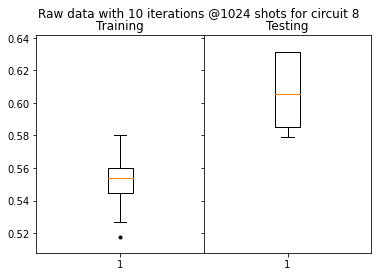

None

In [104]:
for index, run in enumerate(pure_runs):
    title = "Raw data with 10 iterations @" + str(n_shots) + " shots for circuit " + str(index+1)
    plot_boxplots(run, title, index+1, save=True)

In [45]:
normalized_runs = []
display(print("Testing normalized dataset"))
for circuit in circuits:
    training_data = []
    testing_data = []
    for i in range(10):
        display(print('run: ' + str(i+1)))
        classifier = get_classifier(circuit.copy())
        score_train, score_test = fit_and_score(classifier, datasets[1], targets)
        training_data.append(score_train)
        testing_data.append(score_test)
    display(print('Circuit done'))
    normalized_runs.append([training_data, testing_data])

Testing normalized dataset


None

run: 1


None

Mean Accuracy training: 0.7321428571428571
Mean Accuracy testing: 0.868421052631579
run: 2


None

Mean Accuracy training: 0.6339285714285714
Mean Accuracy testing: 0.7894736842105263
run: 3


None

Mean Accuracy training: 0.6964285714285714
Mean Accuracy testing: 0.7894736842105263
run: 4


None

Mean Accuracy training: 0.8125
Mean Accuracy testing: 0.9473684210526315
run: 5


None

Mean Accuracy training: 0.75
Mean Accuracy testing: 0.8421052631578947
run: 6


None

Mean Accuracy training: 0.8839285714285714
Mean Accuracy testing: 0.9736842105263158
run: 7


None

Mean Accuracy training: 0.8571428571428571
Mean Accuracy testing: 0.9736842105263158
run: 8


None

Mean Accuracy training: 0.5267857142857143
Mean Accuracy testing: 0.6842105263157895
run: 9


None

Mean Accuracy training: 0.6517857142857143
Mean Accuracy testing: 0.6842105263157895
run: 10


None

Mean Accuracy training: 0.8214285714285714
Mean Accuracy testing: 0.8421052631578947
Circuit done


None

run: 1


None

Mean Accuracy training: 0.7053571428571429
Mean Accuracy testing: 0.7894736842105263
run: 2


None

Mean Accuracy training: 0.6785714285714286
Mean Accuracy testing: 0.8421052631578947
run: 3


None

Mean Accuracy training: 0.8392857142857143
Mean Accuracy testing: 0.9473684210526315
run: 4


None

Mean Accuracy training: 0.6696428571428571
Mean Accuracy testing: 0.7368421052631579
run: 5


None

Mean Accuracy training: 0.6607142857142857
Mean Accuracy testing: 0.631578947368421
run: 6


None

Mean Accuracy training: 0.6964285714285714
Mean Accuracy testing: 0.8157894736842105
run: 7


None

Mean Accuracy training: 0.7321428571428571
Mean Accuracy testing: 0.8947368421052632
run: 8


None

Mean Accuracy training: 0.8125
Mean Accuracy testing: 0.9736842105263158
run: 9


None

Mean Accuracy training: 0.8571428571428571
Mean Accuracy testing: 0.8947368421052632
run: 10


None

Mean Accuracy training: 0.5982142857142857
Mean Accuracy testing: 0.6052631578947368
Circuit done


None

run: 1


None

Mean Accuracy training: 0.8392857142857143
Mean Accuracy testing: 0.868421052631579
run: 2


None

Mean Accuracy training: 0.8392857142857143
Mean Accuracy testing: 0.9473684210526315
run: 3


None

Mean Accuracy training: 0.6785714285714286
Mean Accuracy testing: 0.7368421052631579
run: 4


None

Mean Accuracy training: 0.6875
Mean Accuracy testing: 0.7894736842105263
run: 5


None

Mean Accuracy training: 0.7857142857142857
Mean Accuracy testing: 0.868421052631579
run: 6


None

Mean Accuracy training: 0.875
Mean Accuracy testing: 0.8947368421052632
run: 7


None

Mean Accuracy training: 0.8125
Mean Accuracy testing: 1.0
run: 8


None

Mean Accuracy training: 0.6875
Mean Accuracy testing: 0.8157894736842105
run: 9


None

Mean Accuracy training: 0.6785714285714286
Mean Accuracy testing: 0.7894736842105263
run: 10


None

Mean Accuracy training: 0.8482142857142857
Mean Accuracy testing: 0.9210526315789473
Circuit done


None

run: 1


None

Mean Accuracy training: 0.6517857142857143
Mean Accuracy testing: 0.7105263157894737
run: 2


None

Mean Accuracy training: 0.6517857142857143
Mean Accuracy testing: 0.7105263157894737
run: 3


None

Mean Accuracy training: 0.6964285714285714
Mean Accuracy testing: 0.7894736842105263
run: 4


None

Mean Accuracy training: 0.5625
Mean Accuracy testing: 0.5263157894736842
run: 5


None

Mean Accuracy training: 0.375
Mean Accuracy testing: 0.3684210526315789
run: 6


None

Mean Accuracy training: 0.5
Mean Accuracy testing: 0.5526315789473685
run: 7


None

Mean Accuracy training: 0.7767857142857143
Mean Accuracy testing: 0.8947368421052632
run: 8


None

Mean Accuracy training: 0.6339285714285714
Mean Accuracy testing: 0.6842105263157895
run: 9


None

Mean Accuracy training: 0.6607142857142857
Mean Accuracy testing: 0.7631578947368421
run: 10


None

Mean Accuracy training: 0.7321428571428571
Mean Accuracy testing: 0.7894736842105263
Circuit done


None

run: 1


None

Mean Accuracy training: 0.4017857142857143
Mean Accuracy testing: 0.3684210526315789
run: 2


None

Mean Accuracy training: 0.7232142857142857
Mean Accuracy testing: 0.8157894736842105
run: 3


None

Mean Accuracy training: 0.6875
Mean Accuracy testing: 0.7631578947368421
run: 4


None

Mean Accuracy training: 0.5535714285714286
Mean Accuracy testing: 0.6842105263157895
run: 5


None

Mean Accuracy training: 0.6607142857142857
Mean Accuracy testing: 0.7894736842105263
run: 6


None

Mean Accuracy training: 0.6785714285714286
Mean Accuracy testing: 0.7631578947368421
run: 7


None

Mean Accuracy training: 0.6785714285714286
Mean Accuracy testing: 0.7631578947368421
run: 8


None

Mean Accuracy training: 0.35714285714285715
Mean Accuracy testing: 0.39473684210526316
run: 9


None

Mean Accuracy training: 0.6964285714285714
Mean Accuracy testing: 0.8157894736842105
run: 10


None

Mean Accuracy training: 0.6160714285714286
Mean Accuracy testing: 0.5789473684210527
Circuit done


None

run: 1


None

Mean Accuracy training: 0.5446428571428571
Mean Accuracy testing: 0.631578947368421
run: 2


None

Mean Accuracy training: 0.9285714285714286
Mean Accuracy testing: 1.0
run: 3


None

Mean Accuracy training: 0.5357142857142857
Mean Accuracy testing: 0.6052631578947368
run: 4


None

Mean Accuracy training: 0.39285714285714285
Mean Accuracy testing: 0.47368421052631576
run: 5


None

Mean Accuracy training: 0.8303571428571429
Mean Accuracy testing: 0.868421052631579
run: 6


None

Mean Accuracy training: 0.8660714285714286
Mean Accuracy testing: 0.9473684210526315
run: 7


None

Mean Accuracy training: 0.5178571428571429
Mean Accuracy testing: 0.5789473684210527
run: 8


None

Mean Accuracy training: 0.8125
Mean Accuracy testing: 0.868421052631579
run: 9


None

Mean Accuracy training: 0.9553571428571429
Mean Accuracy testing: 1.0
run: 10


None

Mean Accuracy training: 0.5714285714285714
Mean Accuracy testing: 0.6842105263157895
Circuit done


None

run: 1


None

Mean Accuracy training: 0.7946428571428571
Mean Accuracy testing: 0.8421052631578947
run: 2


None

Mean Accuracy training: 0.8214285714285714
Mean Accuracy testing: 0.9210526315789473
run: 3


None

Mean Accuracy training: 0.8303571428571429
Mean Accuracy testing: 0.8947368421052632
run: 4


None

Mean Accuracy training: 0.8214285714285714
Mean Accuracy testing: 0.8947368421052632
run: 5


None

Mean Accuracy training: 0.8660714285714286
Mean Accuracy testing: 0.9210526315789473
run: 6


None

Mean Accuracy training: 0.8214285714285714
Mean Accuracy testing: 0.8157894736842105
run: 7


None

Mean Accuracy training: 0.8571428571428571
Mean Accuracy testing: 0.8947368421052632
run: 8


None

Mean Accuracy training: 0.8660714285714286
Mean Accuracy testing: 0.868421052631579
run: 9


None

Mean Accuracy training: 0.7321428571428571
Mean Accuracy testing: 0.7368421052631579
run: 10


None

Mean Accuracy training: 0.6339285714285714
Mean Accuracy testing: 0.6842105263157895
Circuit done


None

run: 1


None

Mean Accuracy training: 0.6071428571428571
Mean Accuracy testing: 0.631578947368421
run: 2


None

Mean Accuracy training: 0.6428571428571429
Mean Accuracy testing: 0.6578947368421053
run: 3


None

Mean Accuracy training: 0.6339285714285714
Mean Accuracy testing: 0.6578947368421053
run: 4


None

Mean Accuracy training: 0.4732142857142857
Mean Accuracy testing: 0.5526315789473685
run: 5


None

Mean Accuracy training: 0.6339285714285714
Mean Accuracy testing: 0.6578947368421053
run: 6


None

Mean Accuracy training: 0.6339285714285714
Mean Accuracy testing: 0.6578947368421053
run: 7


None

Mean Accuracy training: 0.5535714285714286
Mean Accuracy testing: 0.6052631578947368
run: 8


None

Mean Accuracy training: 0.6339285714285714
Mean Accuracy testing: 0.6578947368421053
run: 9


None

Mean Accuracy training: 0.6071428571428571
Mean Accuracy testing: 0.6052631578947368
run: 10


None

Mean Accuracy training: 0.5892857142857143
Mean Accuracy testing: 0.6052631578947368
Circuit done


None

In [48]:
print(normalized_runs)

[[[0.7321428571428571, 0.6339285714285714, 0.6964285714285714, 0.8125, 0.75, 0.8839285714285714, 0.8571428571428571, 0.5267857142857143, 0.6517857142857143, 0.8214285714285714], [0.868421052631579, 0.7894736842105263, 0.7894736842105263, 0.9473684210526315, 0.8421052631578947, 0.9736842105263158, 0.9736842105263158, 0.6842105263157895, 0.6842105263157895, 0.8421052631578947]], [[0.7053571428571429, 0.6785714285714286, 0.8392857142857143, 0.6696428571428571, 0.6607142857142857, 0.6964285714285714, 0.7321428571428571, 0.8125, 0.8571428571428571, 0.5982142857142857], [0.7894736842105263, 0.8421052631578947, 0.9473684210526315, 0.7368421052631579, 0.631578947368421, 0.8157894736842105, 0.8947368421052632, 0.9736842105263158, 0.8947368421052632, 0.6052631578947368]], [[0.8392857142857143, 0.8392857142857143, 0.6785714285714286, 0.6875, 0.7857142857142857, 0.875, 0.8125, 0.6875, 0.6785714285714286, 0.8482142857142857], [0.868421052631579, 0.9473684210526315, 0.7368421052631579, 0.78947368421

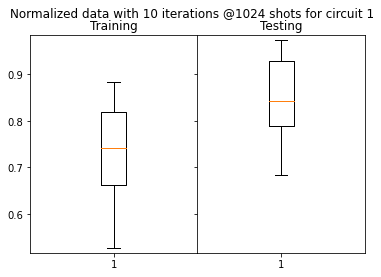

None

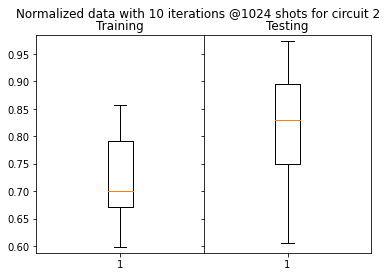

None

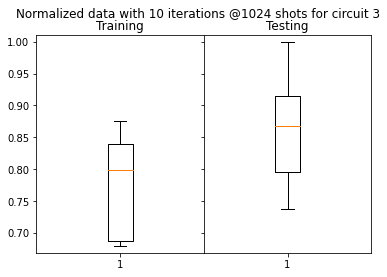

None

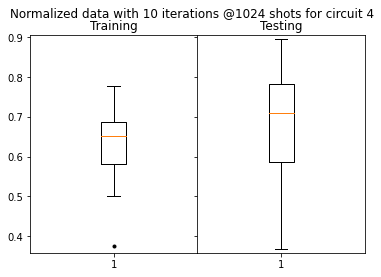

None

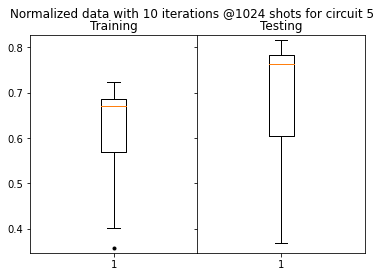

None

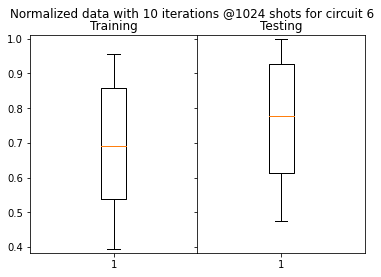

None

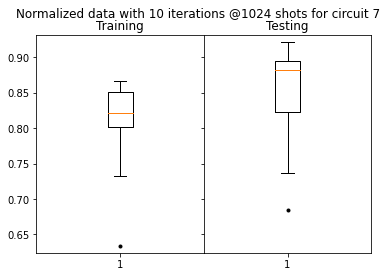

None

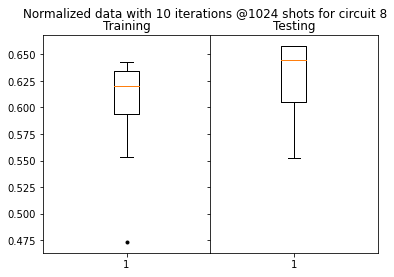

None

In [105]:
for index, run in enumerate(normalized_runs):
    title = "Normalized data with 10 iterations @" + str(n_shots) + " shots for circuit " + str(index+1)
    plot_boxplots(run, title, index+1, save=True)

In [46]:
pified_runs = []
display(print("Testing pified dataset"))
for circuit in circuits:
    training_data = []
    testing_data = []
    for i in range(10):
        display(print('run: ' + str(i+1)))
        classifier = get_classifier(circuit.copy())
        score_train, score_test = fit_and_score(classifier, datasets[2], targets)
        training_data.append(score_train)
        testing_data.append(score_test)
    display(print('Circuit done'))
    pified_runs.append([training_data, testing_data])

Testing pified dataset


None

run: 1


None

Mean Accuracy training: 0.75
Mean Accuracy testing: 0.7631578947368421
run: 2


None

Mean Accuracy training: 0.7678571428571429
Mean Accuracy testing: 0.7105263157894737
run: 3


None

Mean Accuracy training: 0.8571428571428571
Mean Accuracy testing: 0.9736842105263158
run: 4


None

Mean Accuracy training: 0.8125
Mean Accuracy testing: 0.868421052631579
run: 5


None

Mean Accuracy training: 0.7857142857142857
Mean Accuracy testing: 0.9473684210526315
run: 6


None

Mean Accuracy training: 0.6339285714285714
Mean Accuracy testing: 0.5526315789473685
run: 7


None

Mean Accuracy training: 0.7767857142857143
Mean Accuracy testing: 0.9210526315789473
run: 8


None

Mean Accuracy training: 0.7589285714285714
Mean Accuracy testing: 0.7894736842105263
run: 9


None

Mean Accuracy training: 0.6785714285714286
Mean Accuracy testing: 0.7894736842105263
run: 10


None

Mean Accuracy training: 0.6428571428571429
Mean Accuracy testing: 0.5789473684210527
Circuit done


None

run: 1


None

Mean Accuracy training: 0.7142857142857143
Mean Accuracy testing: 0.6578947368421053
run: 2


None

Mean Accuracy training: 0.7142857142857143
Mean Accuracy testing: 0.6842105263157895
run: 3


None

Mean Accuracy training: 0.7410714285714286
Mean Accuracy testing: 0.7631578947368421
run: 4


None

Mean Accuracy training: 0.7410714285714286
Mean Accuracy testing: 0.7368421052631579
run: 5


None

Mean Accuracy training: 0.75
Mean Accuracy testing: 0.9473684210526315
run: 6


None

Mean Accuracy training: 0.5982142857142857
Mean Accuracy testing: 0.5526315789473685
run: 7


None

Mean Accuracy training: 0.6428571428571429
Mean Accuracy testing: 0.47368421052631576
run: 8


None

Mean Accuracy training: 0.7946428571428571
Mean Accuracy testing: 0.7631578947368421
run: 9


None

Mean Accuracy training: 0.8035714285714286
Mean Accuracy testing: 0.9210526315789473
run: 10


None

Mean Accuracy training: 0.6964285714285714
Mean Accuracy testing: 0.7368421052631579
Circuit done


None

run: 1


None

Mean Accuracy training: 0.5714285714285714
Mean Accuracy testing: 0.5
run: 2


None

Mean Accuracy training: 0.48214285714285715
Mean Accuracy testing: 0.47368421052631576
run: 3


None

Mean Accuracy training: 0.5803571428571429
Mean Accuracy testing: 0.47368421052631576
run: 4


None

Mean Accuracy training: 0.6071428571428571
Mean Accuracy testing: 0.7105263157894737
run: 5


None

Mean Accuracy training: 0.6607142857142857
Mean Accuracy testing: 0.5526315789473685
run: 6


None

Mean Accuracy training: 0.49107142857142855
Mean Accuracy testing: 0.47368421052631576
run: 7


None

Mean Accuracy training: 0.6785714285714286
Mean Accuracy testing: 0.5526315789473685
run: 8


None

Mean Accuracy training: 0.5714285714285714
Mean Accuracy testing: 0.5263157894736842
run: 9


None

Mean Accuracy training: 0.6160714285714286
Mean Accuracy testing: 0.7631578947368421
run: 10


None

Mean Accuracy training: 0.6875
Mean Accuracy testing: 0.631578947368421
Circuit done


None

run: 1


None

Mean Accuracy training: 0.8125
Mean Accuracy testing: 0.868421052631579
run: 2


None

Mean Accuracy training: 0.7767857142857143
Mean Accuracy testing: 0.6842105263157895
run: 3


None

Mean Accuracy training: 0.6160714285714286
Mean Accuracy testing: 0.7894736842105263
run: 4


None

Mean Accuracy training: 0.5982142857142857
Mean Accuracy testing: 0.47368421052631576
run: 5


None

Mean Accuracy training: 0.6428571428571429
Mean Accuracy testing: 0.631578947368421
run: 6


None

Mean Accuracy training: 0.7321428571428571
Mean Accuracy testing: 0.7631578947368421
run: 7


None

Mean Accuracy training: 0.7946428571428571
Mean Accuracy testing: 0.868421052631579
run: 8


None

Mean Accuracy training: 0.4642857142857143
Mean Accuracy testing: 0.5
run: 9


None

Mean Accuracy training: 0.6785714285714286
Mean Accuracy testing: 0.6578947368421053
run: 10


None

Mean Accuracy training: 0.6607142857142857
Mean Accuracy testing: 0.6578947368421053
Circuit done


None

run: 1


None

Mean Accuracy training: 0.8035714285714286
Mean Accuracy testing: 0.8947368421052632
run: 2


None

Mean Accuracy training: 0.6339285714285714
Mean Accuracy testing: 0.5526315789473685
run: 3


None

Mean Accuracy training: 0.7321428571428571
Mean Accuracy testing: 0.7894736842105263
run: 4


None

Mean Accuracy training: 0.8214285714285714
Mean Accuracy testing: 0.7894736842105263
run: 5


None

Mean Accuracy training: 0.8125
Mean Accuracy testing: 0.7894736842105263
run: 6


None

Mean Accuracy training: 0.7857142857142857
Mean Accuracy testing: 0.8157894736842105
run: 7


None

Mean Accuracy training: 0.75
Mean Accuracy testing: 0.7631578947368421
run: 8


None

Mean Accuracy training: 0.7678571428571429
Mean Accuracy testing: 0.868421052631579
run: 9


None

Mean Accuracy training: 0.7232142857142857
Mean Accuracy testing: 0.7368421052631579
run: 10


None

Mean Accuracy training: 0.6339285714285714
Mean Accuracy testing: 0.5
Circuit done


None

run: 1


None

Mean Accuracy training: 0.6696428571428571
Mean Accuracy testing: 0.8421052631578947
run: 2


None

Mean Accuracy training: 0.5714285714285714
Mean Accuracy testing: 0.7105263157894737
run: 3


None

Mean Accuracy training: 0.6339285714285714
Mean Accuracy testing: 0.6578947368421053
run: 4


None

Mean Accuracy training: 0.7767857142857143
Mean Accuracy testing: 0.8947368421052632
run: 5


None

Mean Accuracy training: 0.7767857142857143
Mean Accuracy testing: 0.8421052631578947
run: 6


None

Mean Accuracy training: 0.6607142857142857
Mean Accuracy testing: 0.7631578947368421
run: 7


None

Mean Accuracy training: 0.7410714285714286
Mean Accuracy testing: 0.868421052631579
run: 8


None

Mean Accuracy training: 0.7321428571428571
Mean Accuracy testing: 0.868421052631579
run: 9


None

Mean Accuracy training: 0.5535714285714286
Mean Accuracy testing: 0.5789473684210527
run: 10


None

Mean Accuracy training: 0.5267857142857143
Mean Accuracy testing: 0.631578947368421
Circuit done


None

run: 1


None

Mean Accuracy training: 0.6339285714285714
Mean Accuracy testing: 0.631578947368421
run: 2


None

Mean Accuracy training: 0.6607142857142857
Mean Accuracy testing: 0.6578947368421053
run: 3


None

Mean Accuracy training: 0.6339285714285714
Mean Accuracy testing: 0.7894736842105263
run: 4


None

Mean Accuracy training: 0.6696428571428571
Mean Accuracy testing: 0.6842105263157895
run: 5


None

Mean Accuracy training: 0.5982142857142857
Mean Accuracy testing: 0.6842105263157895
run: 6


None

Mean Accuracy training: 0.6785714285714286
Mean Accuracy testing: 0.6842105263157895
run: 7


None

Mean Accuracy training: 0.6160714285714286
Mean Accuracy testing: 0.7894736842105263
run: 8


None

Mean Accuracy training: 0.6160714285714286
Mean Accuracy testing: 0.6578947368421053
run: 9


None

Mean Accuracy training: 0.6428571428571429
Mean Accuracy testing: 0.7368421052631579
run: 10


None

Mean Accuracy training: 0.6517857142857143
Mean Accuracy testing: 0.8157894736842105
Circuit done


None

run: 1


None

Mean Accuracy training: 0.4375
Mean Accuracy testing: 0.4473684210526316
run: 2


None

Mean Accuracy training: 0.39285714285714285
Mean Accuracy testing: 0.3157894736842105
run: 3


None

Mean Accuracy training: 0.5267857142857143
Mean Accuracy testing: 0.5526315789473685
run: 4


None

Mean Accuracy training: 0.5178571428571429
Mean Accuracy testing: 0.7105263157894737
run: 5


None

Mean Accuracy training: 0.3392857142857143
Mean Accuracy testing: 0.23684210526315788
run: 6


None

Mean Accuracy training: 0.45535714285714285
Mean Accuracy testing: 0.5526315789473685
run: 7


None

Mean Accuracy training: 0.4375
Mean Accuracy testing: 0.47368421052631576
run: 8


None

Mean Accuracy training: 0.45535714285714285
Mean Accuracy testing: 0.5526315789473685
run: 9


None

Mean Accuracy training: 0.44642857142857145
Mean Accuracy testing: 0.5263157894736842
run: 10


None

Mean Accuracy training: 0.32142857142857145
Mean Accuracy testing: 0.21052631578947367
Circuit done


None

In [49]:
print(pified_runs)

[[[0.75, 0.7678571428571429, 0.8571428571428571, 0.8125, 0.7857142857142857, 0.6339285714285714, 0.7767857142857143, 0.7589285714285714, 0.6785714285714286, 0.6428571428571429], [0.7631578947368421, 0.7105263157894737, 0.9736842105263158, 0.868421052631579, 0.9473684210526315, 0.5526315789473685, 0.9210526315789473, 0.7894736842105263, 0.7894736842105263, 0.5789473684210527]], [[0.7142857142857143, 0.7142857142857143, 0.7410714285714286, 0.7410714285714286, 0.75, 0.5982142857142857, 0.6428571428571429, 0.7946428571428571, 0.8035714285714286, 0.6964285714285714], [0.6578947368421053, 0.6842105263157895, 0.7631578947368421, 0.7368421052631579, 0.9473684210526315, 0.5526315789473685, 0.47368421052631576, 0.7631578947368421, 0.9210526315789473, 0.7368421052631579]], [[0.5714285714285714, 0.48214285714285715, 0.5803571428571429, 0.6071428571428571, 0.6607142857142857, 0.49107142857142855, 0.6785714285714286, 0.5714285714285714, 0.6160714285714286, 0.6875], [0.5, 0.47368421052631576, 0.47368

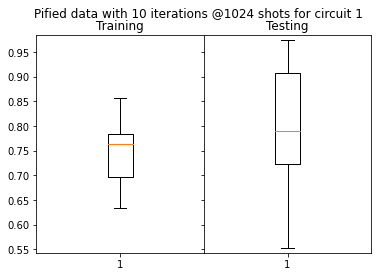

None

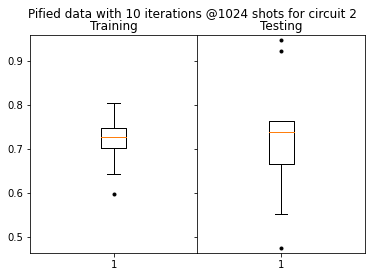

None

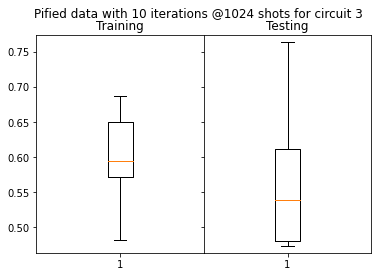

None

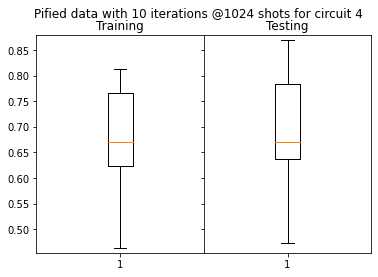

None

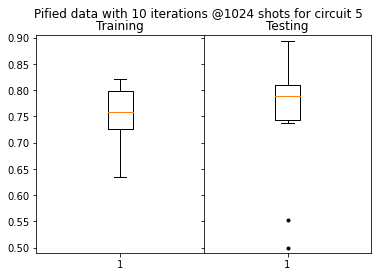

None

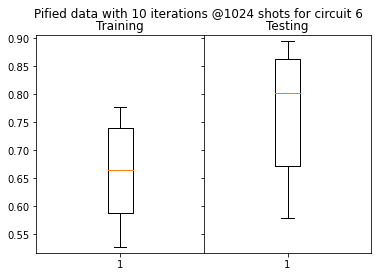

None

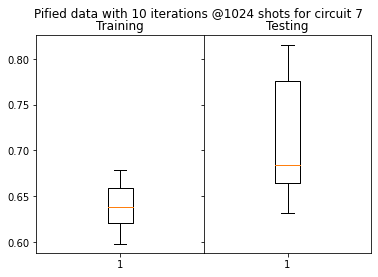

None

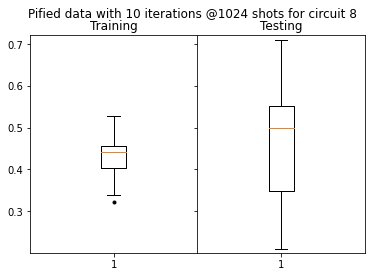

None

In [106]:
for index, run in enumerate(pified_runs):
    title = "Pified data with 10 iterations @" + str(n_shots) + " shots for circuit " + str(index+1)
    plot_boxplots(run, title, index+1, save=True)

In [97]:
#Save all training measurments
with open(training_measurments_path + '/raw_data.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=';',)
    writer.writerow(['circuit', 'type', 'accuracy'])
    for index, circuit in enumerate(pure_runs):
        for jndex, run in enumerate(circuit[0]):
            writer.writerow(np.append([index+1, 'Training'], run))
        for jndex, run in enumerate(circuit[0]):
            writer.writerow(np.append([index+1, 'Testing'], run))

#Save all training measurments
with open(training_measurments_path + '/normalized_data.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=';',)
    writer.writerow(['circuit', 'type', 'accuracy'])
    for index, circuit in enumerate(normalized_runs):
        for jndex, run in enumerate(circuit[0]):
            writer.writerow(np.append([index+1, 'Training'], run))
        for jndex, run in enumerate(circuit[0]):
            writer.writerow(np.append([index+1, 'Testing'], run))

#Save all training measurments
with open(training_measurments_path + '/pified_data.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=';',)
    writer.writerow(['circuit', 'type', 'accuracy'])
    for index, circuit in enumerate(pified_runs):
        for jndex, run in enumerate(circuit[0]):
            writer.writerow(np.append([index+1, 'Training'], run))
        for jndex, run in enumerate(circuit[0]):
            writer.writerow(np.append([index+1, 'Testing'], run))